In [75]:
import numpy as np
import time
import tracemalloc
import timeit
import matplotlib.pyplot as plt

In [76]:
int_arrays = [
    ("50", np.random.randint(0, 100, size=50)),
    ("100", np.random.randint(0, 100, size=100)),
    ("500", np.random.randint(0, 1000, size=500)),
    ("1000", np.random.randint(0, 2000, size=1000)),
    ("2000", np.random.randint(0, 25000, size=2000))
]

float_arrays = [
    ("50", np.random.uniform(0.01, 99.9, size=50)),
    ("100", np.random.uniform(0.01, 199.9, size=100)),
    ("500", np.random.uniform(0.01, 699.9, size=500)),
    ("1000", np.random.uniform(0.01, 1999.9, size=1000)),
    ("2000", np.random.uniform(0.01, 2999.9, size=2000))
]


In [77]:
class BinaryTreeNode:
    def __init__(self, data):
        self.left = None
        self.right = None
        self.data = data

    def insert(self, data):
        if self.data is not None:
            if data < self.data:
                if self.left is None:
                    self.left = BinaryTreeNode(data)
                else:
                    self.left.insert(data)
            elif data > self.data:
                if self.right is None:
                    self.right = BinaryTreeNode(data)
                else:
                    self.right.insert(data)
        else:
            self.data = data

    def delete(self, key):
        if self is None:
            return self
        if key < self.data:
            self.left = self.left.delete(key)
        elif key > self.data:
            self.right = self.right.delete(key)
        else:
            if self.left is None:
                temp = self.right
                self = None
                return temp
            elif self.right is None:
                temp = self.left
                self = None
                return temp
            temp = self.right
            while temp.left is not None:
                temp = temp.left
            self.data = temp.data
            self.right = self.right.delete(temp.data)
        return self


In [78]:
class BTreeNode:
    def __init__(self, t, leaf=True):
        self.t = t
        self.leaf = leaf
        self.keys = []
        self.child = []

    def insert(self, k):
        if not hasattr(self, 'keys') or len(self.keys) == 0:
            self.keys = [k]
        elif len(self.keys) == (2 * self.t) - 1:
            temp = BTreeNode(self.t)
            temp.child.insert(0, self)
            self.split_child(temp, 0)
            temp.insert_non_full(k)
        else:
            self.insert_non_full(k)

    def insert_non_full(self, k):
        i = len(self.keys) - 1
        if self.leaf:
            self.keys.append(k)
            while i >= 0 and k < self.keys[i]:
                self.keys[i + 1] = self.keys[i]
                i -= 1
            self.keys[i + 1] = k
        else:
            while i >= 0 and k < self.keys[i]:
                i -= 1
            i += 1
            if len(self.child) == 0:
                self.child.append(BTreeNode(self.t))
            while i < len(self.child) and len(self.child[i].keys) == (2 * self.t) - 1:
                self.split_child(self.child[i], i)
                if k > self.keys[i]:
                    i += 1
            if i < len(self.child):
                self.child[i].insert_non_full(k)

    def split_child(self, y, i):
        z = BTreeNode(self.t, leaf=y.leaf)
        self.child.insert(i + 1, z)
        mid = self.t - 1
        if len(y.keys) > 0: 
            self.keys.insert(i, y.keys[mid])  
            if len(y.keys) >= 2 * self.t - 1:
                z.keys = y.keys[self.t:2 * self.t - 1]
                y.keys = y.keys[:self.t - 1]
            else:
                z.keys = y.keys[self.t:]
                y.keys = y.keys[:self.t - 1]
        if not y.leaf:
            z.child = y.child[self.t:]
            y.child = y.child[:self.t]

    def delete(self, k):
        i = 0
        while i < len(self.keys) and k > self.keys[i]:
            i += 1

        if i < len(self.keys) and self.keys[i] == k:
            if self.leaf:
                self.keys.pop(i)
            else:
                if len(self.child[i].keys) >= self.t:
                    self.keys[i] = self.child[i].keys.pop()
                else:
                    if len(self.child[i + 1].keys) >= self.t:
                        self.keys[i] = self.child[i + 1].keys.pop(0)
                    else:
                        self.merge(i)
                        self.child[i].delete(k)
                        return
            return

        if self.leaf:
            return

        if len(self.child[i].keys) < self.t:
            self.fill(i)

        self.child[i].delete(k)

    def fill(self, i):
        if i != 0 and len(self.child[i - 1].keys) >= self.t:
            self.child[i].keys.insert(0, self.keys[i - 1])
            if not self.child[i].leaf:
                self.child[i].child.insert(0, self.child[i - 1].child.pop())
            self.keys[i - 1] = self.child[i - 1].keys.pop()
            return
        if i != len(self.keys) and len(self.child[i + 1].keys) >= self.t:
            self.child[i].keys.append(self.keys[i])
            if not self.child[i].leaf:
                self.child[i].child.append(self.child[i + 1].child.pop(0))
            self.keys[i] = self.child[i + 1].keys.pop(0)
            return
        if i != len(self.keys):
            self.merge(i)
            return
        self.merge(i - 1)

    def merge(self, i):
        child = self.child.pop(i + 1)
        if len(child.keys) < self.t:
            self.child[i].keys.append(self.keys.pop(i))
            self.child[i].keys.extend(child.keys)
            if not self.child[i].leaf:
                self.child[i].child.extend(child.child)
        else:
            self.child[i].keys.append(self.keys[i])
            self.keys[i] = child.keys.pop(0)
            self.child[i].child.append(child.child.pop(0))


In [79]:
# Для кожного завдання виконуємо умови, визначаємо час виконання та об'єму пам'яті вставки та видалення останнього елементу
def task_1(array):
    root = BinaryTreeNode(array[0])
    for num in array[1:-1]:  
        root.insert(num)
    start_time = timeit.default_timer()
    tracemalloc.start()
    root.insert(array[-1])
    execution_time = timeit.default_timer() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return execution_time, peak

def task_2(array):
    root = BinaryTreeNode(array[0])
    for num in array[1:]:
        root.insert(num)
    tracemalloc.start()
    start_time = timeit.default_timer()
    root.delete(array[-1])
    execution_time = timeit.default_timer() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return execution_time, peak

def task_3(array):
    b_tree = BTreeNode(2)
    for num in array[:-1]:
        b_tree.insert(num)

    start_time = timeit.default_timer()
    tracemalloc.start()
    b_tree.insert(array[-1])
    execution_time = timeit.default_timer() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return execution_time, peak


def task_4(array):
    b_tree = BTreeNode(2)
    for num in array[:-1]:
        b_tree.insert(num)
    
    start_time = timeit.default_timer()
    tracemalloc.start()
    b_tree.delete(array[-1])
    execution_time = timeit.default_timer() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return execution_time, peak

In [80]:
# Функція виведення графіків 
def plot_results(times_int, times_float, memories_int, memories_float, labels, title):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(times_int, label="Integers")
    plt.plot(times_float, label="Floats")
    plt.title('Execution Time')
    plt.xlabel('Array Size')
    plt.ylabel('Time')
    plt.xticks(range(len(int_arrays)), [label for label, _ in int_arrays], rotation=45)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(memories_int, label="Integers")
    plt.plot(memories_float, label="Floats")
    plt.title('Peak Memory Usage')
    plt.xlabel('Array Size')
    plt.ylabel('Memory (bytes)')
    plt.xticks(range(len(int_arrays)), [label for label, _ in int_arrays], rotation=45)
    plt.legend()

    plt.suptitle(title)
    plt.show()


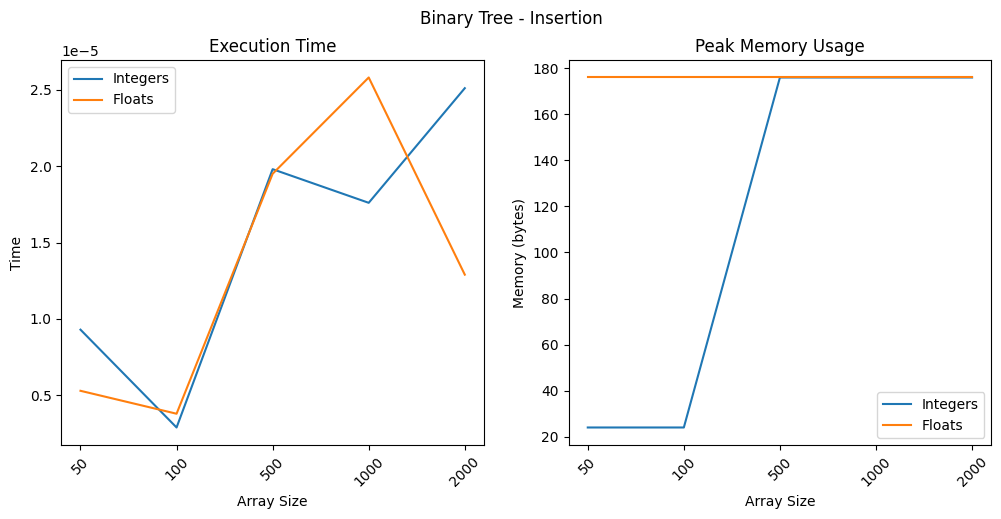

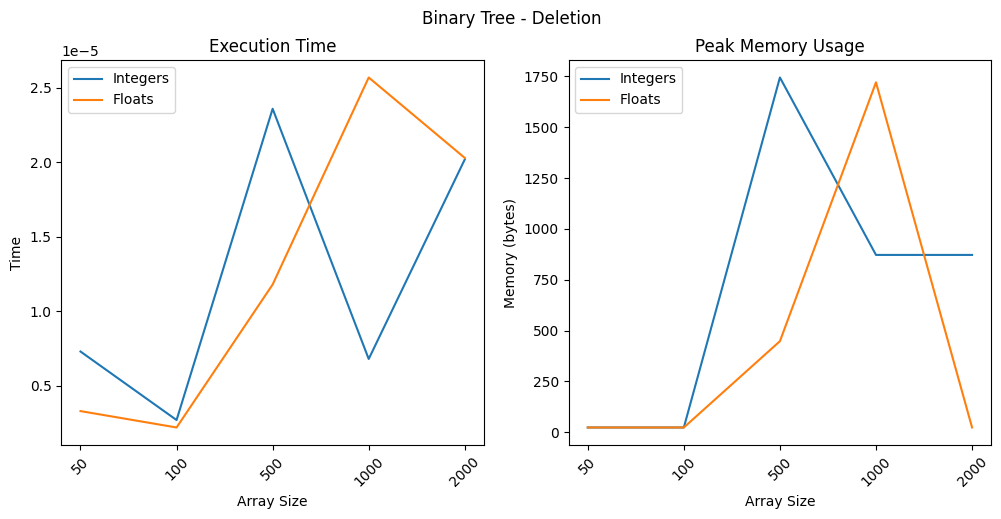

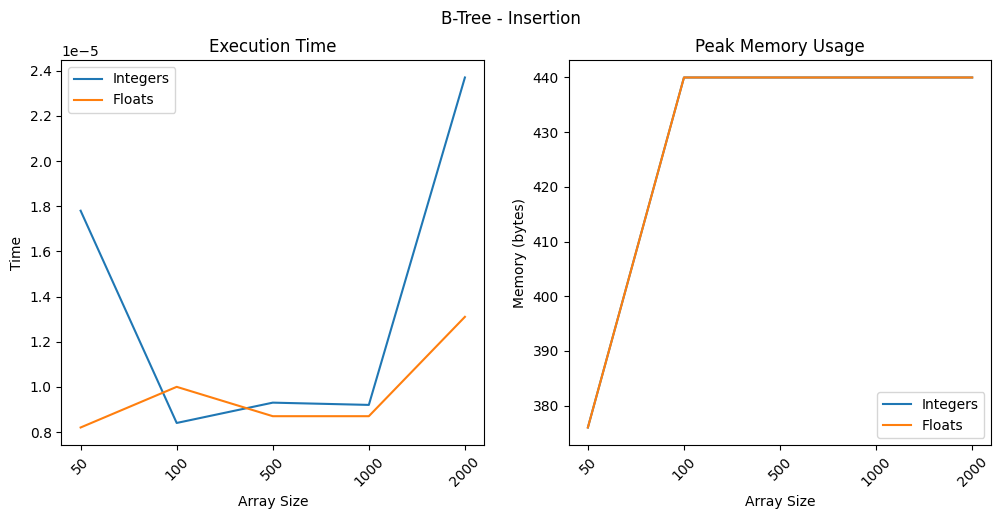

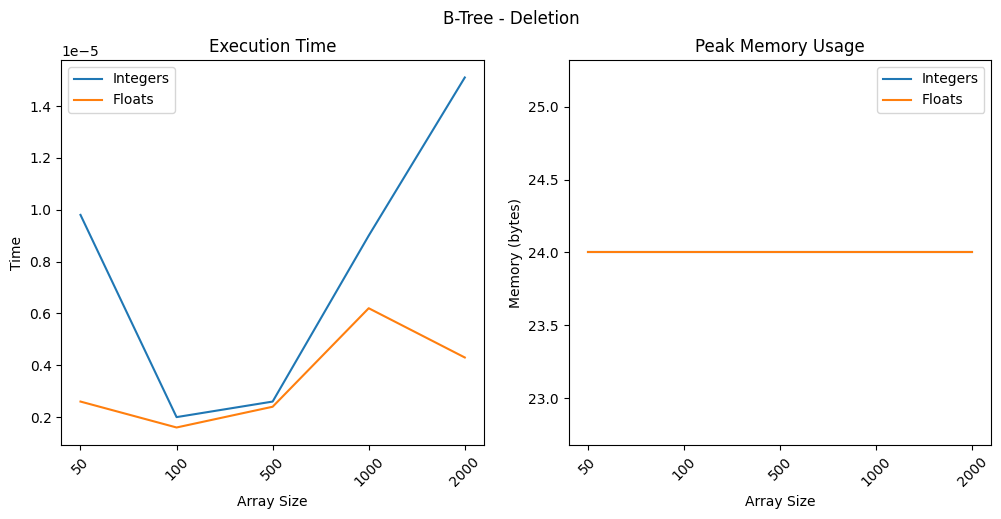

In [81]:
task_functions = [task_1, task_2, task_3, task_4]
task_labels = [("Binary Tree", "Insertion"), 
               ("Binary Tree", "Deletion"), 
               ("B-Tree", "Insertion"), 
               ("B-Tree", "Deletion")]

# Виведення графіків 
for func, label in zip(task_functions, task_labels):
    times_int = []
    memories_int = []
    times_float = []
    memories_float = []

    for (array_label_int, array_int), (array_label_float, array_float) in zip(int_arrays, float_arrays):
        time_taken_int, memory_used_int = func(array_int)
        time_taken_float, memory_used_float = func(array_float)
        times_int.append(time_taken_int)
        memories_int.append(memory_used_int)
        times_float.append(time_taken_float)
        memories_float.append(memory_used_float)

    plot_results(times_int, times_float, memories_int, memories_float, ["Integers", "Floats"], f"{label[0]} - {label[1]}")
